In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import helper
from matplotlib.lines import Line2D

In [2]:
palette = ["#2E610F", "#D9443D", "#7F5072", "#CFA97C", "#43383D"]

sns.set_style("ticks")
sns.set_palette(palette, 5)

In [3]:
exp_measures = pd.read_csv("measures.csv")
exp_measures["dwell_time_s"] = exp_measures["dwell_time"]*exp_measures["RT"] 
exp_measures["dwell_time_binary_coarse"] = pd.qcut(exp_measures['dwell_time'], 2, labels=["low", "high"])
exp_measures["dwell_time_tertile"] = pd.qcut(exp_measures['dwell_time'], 3, precision=2)#, labels=[1, 2, 3])
exp_measures["RT_tertile"] = pd.qcut(exp_measures['RT'], 3, labels=[1, 2, 3])
exp_measures["dwell_time_decile"] = pd.qcut(exp_measures['dwell_time'], 10, precision=2)#, labels=range(1,11))
exp_measures["dwell_time_s_decile"] = pd.qcut(exp_measures['dwell_time_s'], 10)#, labels=range(1,11))
# exp_measures["dwell_time_tertile"] = exp_measures.groupby(["tta_condition", "d_condition", "tta_or_condition"]).apply(lambda m: pd.qcut(m['dwell_time'], 3, labels=[1, 2, 3])).values
# exp_measures["dwell_time_decile"] = exp_measures.groupby(["tta_condition", "d_condition", "tta_or_condition"]).apply(lambda m: pd.qcut(m['dwell_time'], 8, labels=range(1,9))).values

In [3]:
exp_measures

,tta_or_condition,d_condition,tta_condition,is_gap_accepted,RT,subj_id,dwell_time,decision,dwell_time_s,dwell_time_binary_coarse,dwell_time_tertile,RT_tertile,dwell_time_decile,dwell_time_s_decile
0,4,20,4,True,1.195,3,0.826087,Merge,0.987174,high,"(0.76, 1.0]",1,"(0.78, 0.84]","(0.927, 1.036]"
1,4,20,4,True,1.175,3,0.739130,Merge,0.868478,high,"(0.58, 0.76]",1,"(0.72, 0.78]","(0.83, 0.927]"
2,4,20,4,True,1.865,3,0.621622,Merge,1.159324,low,"(0.58, 0.76]",3,"(0.61, 0.67]","(1.036, 1.162]"
3,4,20,4,True,0.923,3,1.000000,Merge,0.923000,high,"(0.76, 1.0]",1,"(0.95, 1.0]","(0.83, 0.927]"
4,4,20,4,True,1.335,3,0.846154,Merge,1.129615,high,"(0.76, 1.0]",2,"(0.84, 0.95]","(1.036, 1.162]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,6,40,6,False,2.433,24,0.541667,Wait,1.317875,low,"(-0.01, 0.58]",3,"(0.5, 0.56]","(1.317, 1.579]"
8630,6,40,6,False,2.185,24,0.813953,Wait,1.778488,high,"(0.76, 1.0]",3,"(0.78, 0.84]","(1.579, 3.962]"
8631,6,40,6,False,1.199,24,0.869565,Wait,1.042609,high,"(0.76, 1.0]",1,"(0.84, 0.95]","(1.036, 1.162]"
8632,6,40,6,False,1.571,24,0.677419,Wait,1.064226,high,"(0.58, 0.76]",2,"(0.67, 0.72]","(1.036, 1.162]"


In [4]:
def plot_var_by_condition(exp_measures, model_measures, var, model_label, include_model=True, include_legend=False, subfigure_labels=None, fig=None, axes=None):
    tta_or_conditions = [4, 6]
    markers=["o", "s"]
    colors = ["C0", "C1"]
    ms=7

    if fig is None:
        fig, axes = plt.subplots(1, 2, figsize=(4,2), sharex=True, sharey=True)

    for tta, ax in zip([4, 6], axes):
        for tta_or, color, marker in zip(tta_or_conditions, colors, markers):
            exp_measures_by_d = exp_measures[(exp_measures.tta_condition == tta) & (exp_measures.tta_or_condition == tta_or)]
            if include_model:
                model_measures_by_d = model_measures[(model_measures.tta_condition==tta) & (model_measures.tta_or_condition==tta_or)]

            if var == "is_gap_accepted":
                psf_ci = helper.get_psf_ci(exp_measures_by_d)
                ax.plot(psf_ci.d_condition, psf_ci.p_go, ls="-", marker=marker, ms=ms, color=color, zorder=10)
                ax.vlines(x=psf_ci.d_condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)
                if include_model:
                    ax.plot(model_measures_by_d.d_condition, model_measures_by_d.is_gap_accepted, color=color, label=tta)
                ax.set_ylim((0, 1))
            else:
                if var == "RT_merge":
                    measures_mean_sem = helper.get_mean_sem(exp_measures_by_d[exp_measures_by_d.is_gap_accepted],
                                                        var="RT", groupby_var="d_condition", n_cutoff=10)
                elif var == "RT_wait":
                    measures_mean_sem = helper.get_mean_sem(exp_measures_by_d[~(exp_measures_by_d.is_gap_accepted)],
                                                        var="RT", groupby_var="d_condition", n_cutoff=10)
                ax.errorbar(measures_mean_sem.index, measures_mean_sem["mean"], yerr=measures_mean_sem["sem"],
                                ls="-", marker=marker, ms=ms, color=color)
                if include_model:
                    ax.plot(model_measures_by_d.d_condition, model_measures_by_d[var], color=color, label=tta)

        ax.set_xlim((exp_measures_by_d.d_condition.min()-5, exp_measures_by_d.d_condition.max()+5))
        # ax.set_xlabel("Distance to vehicle, m", fontsize=12)
        ax.set_title("TTA=%is" % (tta), fontsize=12)

    # axes[0].set_ylabel(var, fontsize=16)
    if var=="is_gap_accepted":
        ylabel = "p(accept)"
        ylim = (0, 1)
    elif var=="RT_merge":
        ylabel = "accept RT"
        ylim = (1, 2)
    elif var=="RT_wait":
        ylabel = "reject RT"
        ylim = (1.5, 3)

    axes[0].set_title(subfigure_labels[0], loc="left", fontsize=12)
    axes[1].set_title(subfigure_labels[1], loc="left", fontsize=12)
    
    axes[0].set_ylabel(ylabel, fontsize=12)

    for ax in axes:
        ax.set_ylim(ylim)

    # sns.despine(offset=5, trim=True)
    plt.tight_layout()

    if include_legend:
        fig.text(x=0.4, y=-0.02, s="Distance gap, m", fontsize=12)
        legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=ms, lw=0, label="Time budget merging lane=%is" % (tta_or_condition))
                           for tta_or_condition, color, marker in zip(tta_or_conditions, colors, markers)]
                           + ([Line2D([0], [0], color="grey", label="Model")] if include_model else []))

        fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.2, 1.00), fontsize=12, frameon=False)
    plt.savefig("output/%s_%s_model_%r.png" % (var, model_label, include_model), bbox_inches="tight", dpi=300)

# Data only

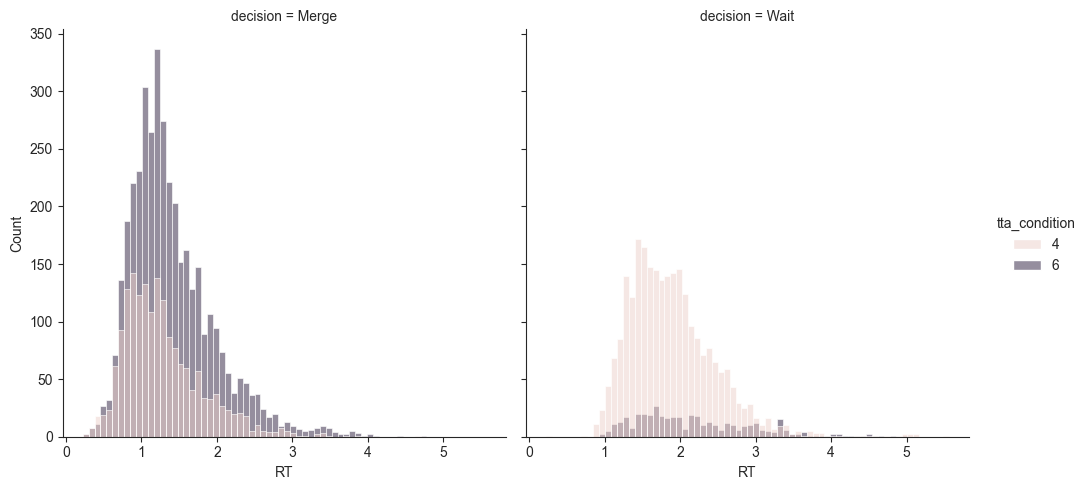

In [60]:
sns.displot(data=exp_measures, x="RT", hue="tta_condition", col="decision") 

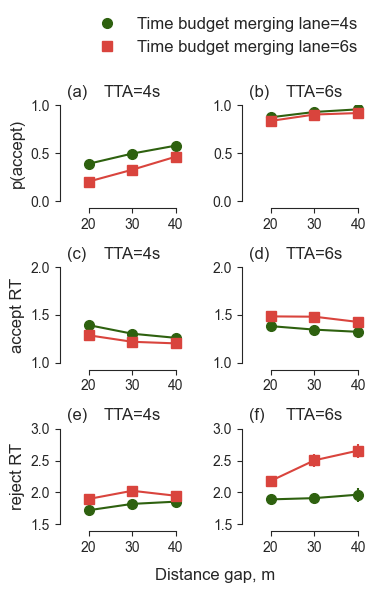

In [114]:
fig, axes = plt.subplots(3, 2, figsize=(4, 5))
plot_var_by_condition(exp_measures, None, var="is_gap_accepted", model_label=None, include_model=False, include_legend=True,subfigure_labels=["(a)", "(b)"], fig=fig, axes=axes[0])

plot_var_by_condition(exp_measures, None, var="RT_merge", model_label=None, include_model=False, include_legend=False,subfigure_labels=["(c)", "(d)"], fig=fig, axes=axes[1])

plot_var_by_condition(exp_measures, None, var="RT_wait", model_label=None, include_model=False, include_legend=False,subfigure_labels=["(e)", "(f)"], fig=fig, axes=axes[2])

sns.despine(offset=5, trim=True)

fig.set_tight_layout(True)
plt.savefig("output/p_accept_RT.pdf", bbox_inches="tight", dpi=300)

# Effect of dwell time on decision

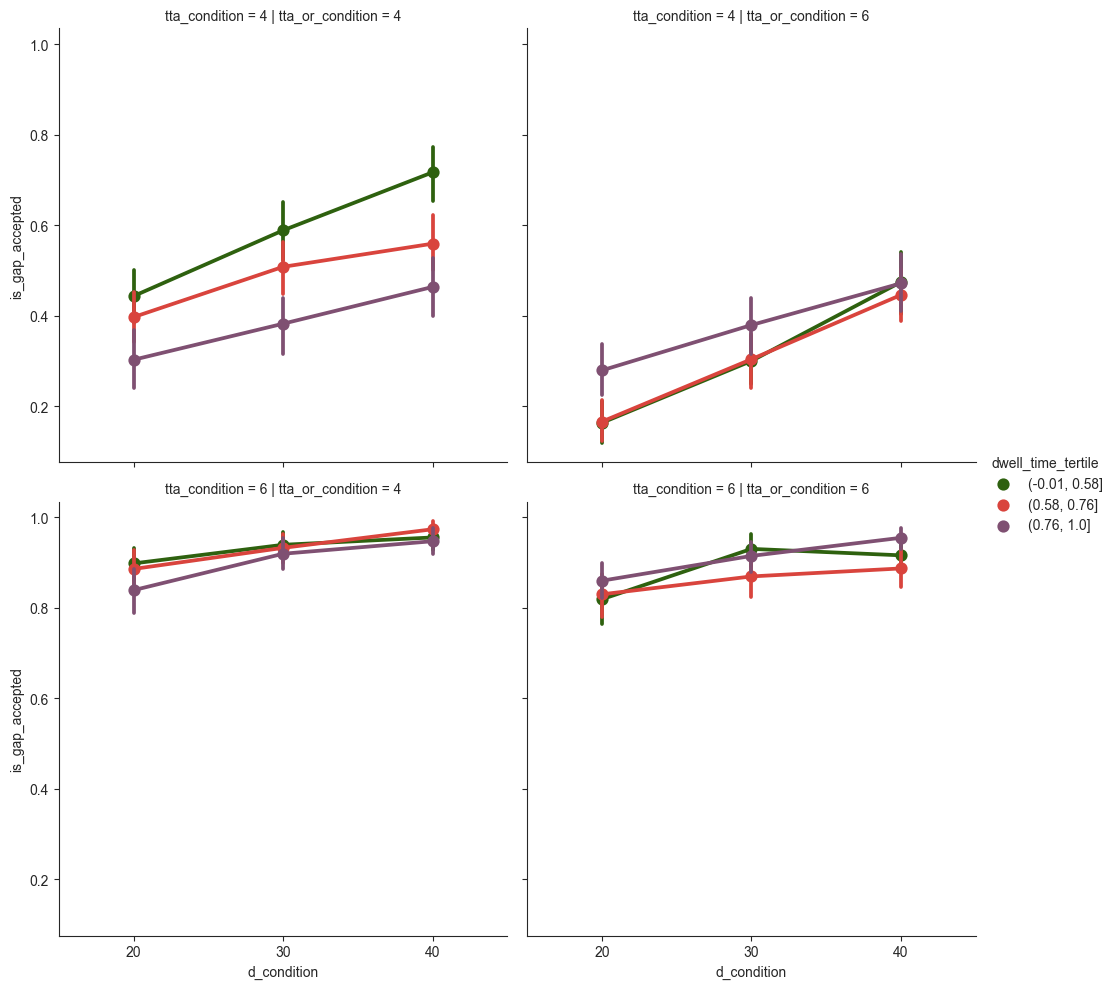

In [154]:
g = sns.catplot(data=exp_measures, x="d_condition", y="is_gap_accepted", hue="dwell_time_tertile", col="tta_or_condition", row="tta_condition", kind="point")

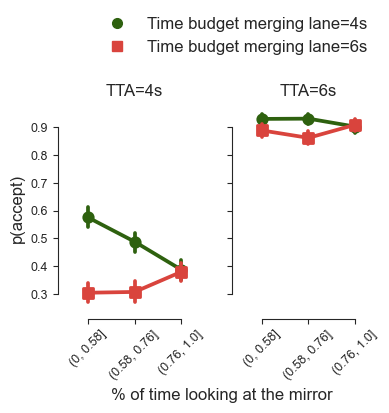

In [151]:
fontsize = 9
height = 3
width = 2

tta_or_conditions = [4, 6]
markers=["o", "s"]
colors = ["C0", "C1"]
ms=7

g = sns.catplot(data=exp_measures, x="dwell_time_tertile", y="is_gap_accepted", hue="tta_or_condition", col="tta_condition", 
                join=True, kind="point", height=height, aspect=width/height, markers=markers)
for ax, TTA in zip(g.axes.flatten(), [4, 6]):
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel("")
    ax.set_ylabel("p(accept)", fontsize=fontsize+3)
    ax.set_title("TTA=%is" % TTA)

labels = [item.get_text() for item in g.axes.flatten()[0].get_xticklabels()]
labels[0] = labels[0].replace("-0.01", "0")
g.axes.flatten()[0].set_xticklabels(labels)
g.axes.flatten()[1].set_xticklabels(labels)
g.legend.set_visible(False)
legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=ms, lw=0, label="Time budget merging lane=%is" % (tta_or_condition)) for tta_or_condition, color, marker in zip(tta_or_conditions, colors, markers)])
plt.figlegend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.2, 1.00), fontsize=12, frameon=False)

plt.figtext(x=0.25, y=-.1, s="% of time looking at the mirror", fontsize=fontsize+3)
sns.despine(offset=5, trim=True)
# plt.savefig("output/p_accept_vs_dwell_time_tertile.pdf", bbox_inches="tight", dpi=300)

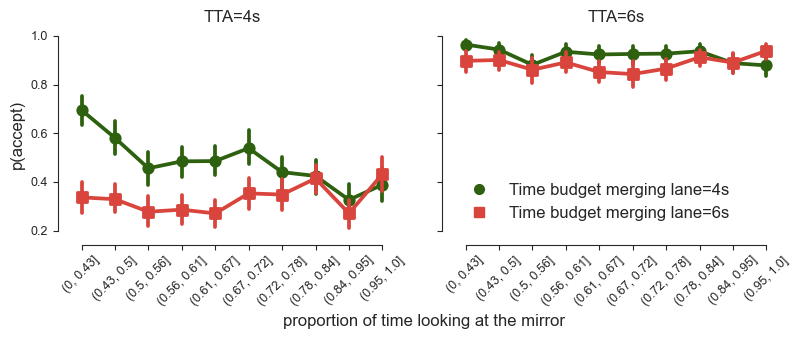

In [9]:
fontsize = 9
height = 3
width = 4

tta_or_conditions = [4, 6]
markers=["o", "s"]
colors = ["C0", "C1"]
ms=7

g = sns.catplot(data=exp_measures, x="dwell_time_decile", y="is_gap_accepted", hue="tta_or_condition", col="tta_condition", 
                join=True, kind="point", height=height, aspect=width/height, markers=markers)
for ax, TTA in zip(g.axes.flatten(), [4, 6]):
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel("")
    ax.set_ylabel("p(accept)", fontsize=fontsize+3)
    ax.set_title("TTA=%is" % TTA)

labels = [item.get_text() for item in g.axes.flatten()[0].get_xticklabels()]
labels[0] = labels[0].replace("-0.01", "0")
g.axes.flatten()[0].set_xticklabels(labels)
g.axes.flatten()[1].set_xticklabels(labels)
g.legend.set_visible(False)
legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=ms, lw=0, label="Time budget merging lane=%is" % (tta_or_condition)) for tta_or_condition, color, marker in zip(tta_or_conditions, colors, markers)])
plt.figlegend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.5, 0.2), fontsize=12, frameon=False)

plt.figtext(x=0.32, y=-.1, s="proportion of time looking at the mirror", fontsize=fontsize+3)
sns.despine(offset=5, trim=True)
plt.savefig("output/p_accept_vs_dwell_time_decile.pdf", bbox_inches="tight", dpi=300)

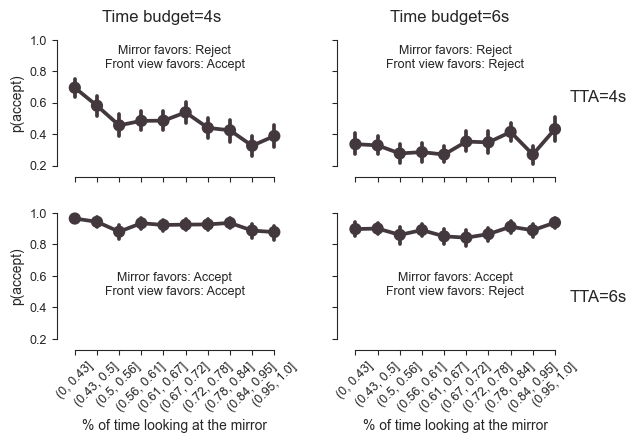

In [110]:
fontsize = 9
height = 2
width = 3

g = sns.catplot(data=exp_measures, x="dwell_time_decile", y="is_gap_accepted", col="tta_or_condition", row="tta_condition", 
                join=True, kind="point", color="C3", height=height, aspect=width/height)

for ax in g.axes.flatten():
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel("% of time looking at the mirror", fontsize=fontsize+1)
    ax.set_ylabel("p(accept)", fontsize=fontsize+1)

labels = [item.get_text() for item in g.axes.flatten()[2].get_xticklabels()]
labels[0] = labels[0].replace("-0.01", "0")
g.axes.flatten()[2].set_xticklabels(labels)
g.axes.flatten()[3].set_xticklabels(labels)

plt.figtext(s="Time budget=4s", x=0.17, y=0.95, fontsize=fontsize+3)
plt.figtext(s="Time budget=6s", x=0.65, y=0.95, fontsize=fontsize+3)
plt.figtext(s="TTA=4s", x=0.95, y=0.75, fontsize=fontsize+3)
plt.figtext(s="TTA=6s", x=0.95, y=0.25, fontsize=fontsize+3)
g.axes.flatten()[0].set_title("Mirror favors: Reject\nFront view favors: Accept", fontsize=fontsize, y=0.7)
g.axes.flatten()[1].set_title("Mirror favors: Reject\nFront view favors: Reject", fontsize=fontsize, y=0.7)
g.axes.flatten()[2].set_title("Mirror favors: Accept\nFront view favors: Accept", fontsize=fontsize, y=0.3)
g.axes.flatten()[3].set_title("Mirror favors: Accept\nFront view favors: Reject", fontsize=fontsize, y=0.3)

sns.despine(offset=5, trim=True)
plt.savefig("output/p_accept_vs_dwell_time.pdf", bbox_inches="tight", dpi=300)

# Obsolete

## Modified left-turn model with tta_onramp in both drift and boundary

In [5]:
model_label="left_turn_model"
model_measures = pd.read_csv("model_fit_results/%s/simulation_results/subj_all_measures.csv" % model_label)

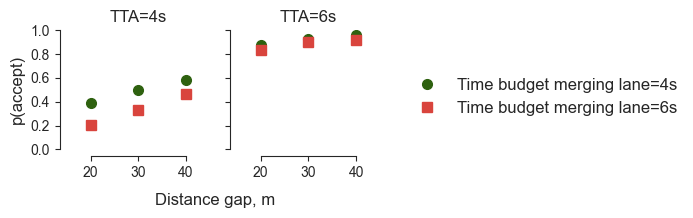

In [40]:
plot_var_by_condition(exp_measures, None, var="is_gap_accepted", model_label=model_label,
                      include_model=False, include_legend=True)

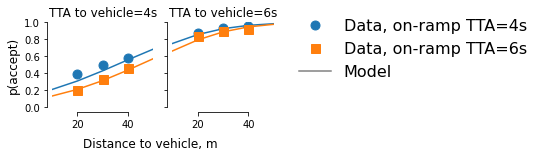

In [6]:
plot_var_by_condition(exp_measures, model_measures, var="is_gap_accepted", model_label=model_label,
                      include_model=True, include_legend=True)

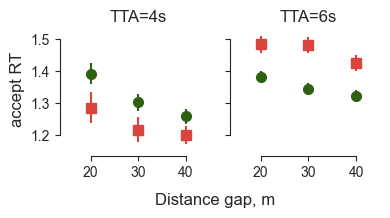

In [35]:
plot_var_by_condition(exp_measures, model_measures, var="RT_merge", model_label=model_label, include_model=False)

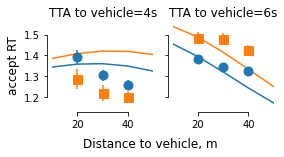

In [8]:
plot_var_by_condition(exp_measures, model_measures, var="RT_merge", model_label=model_label, include_model=True)

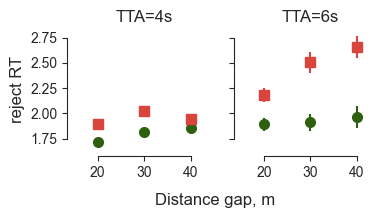

In [36]:
plot_var_by_condition(exp_measures, model_measures, var="RT_wait", model_label=model_label, include_model=False)

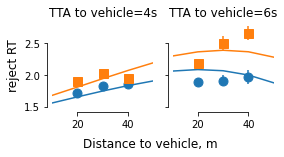

In [44]:
plot_var_by_condition(exp_measures, model_measures, var="RT_wait", model_label=model_label, include_model=True)

## Gaze-dependent model

In [9]:
model_label="gaze_dependent_model"
model_measures = pd.read_csv("model_fit_results/%s/simulation_results/subj_all_measures.csv" % (model_label))

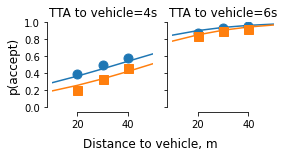

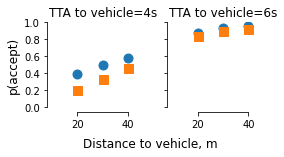

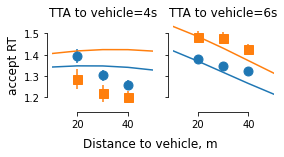

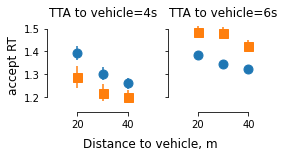

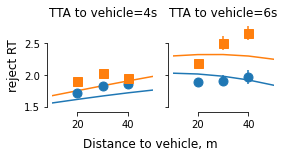

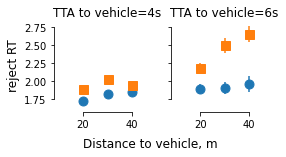

In [46]:
for var in ["is_gap_accepted", "RT_merge", "RT_wait"]:
    for include_model in [True, False]:
        plot_var_by_condition(exp_measures, model_measures, var=var, model_label=model_label, include_model=include_model)

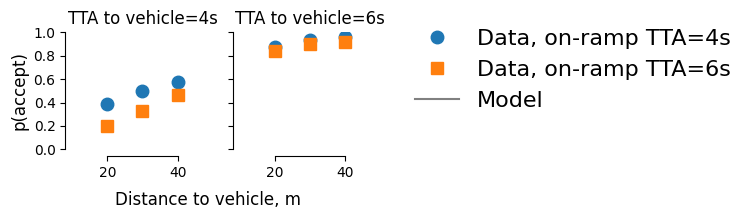

In [14]:
plot_var_by_condition(exp_measures, model_measures, var="is_gap_accepted", model_label=model_label, include_model=False, include_legend=True)

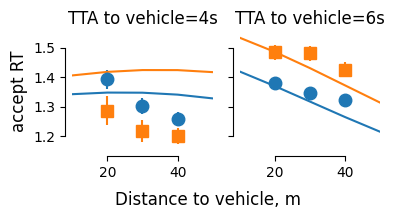

In [13]:
plot_var_by_condition(exp_measures, model_measures, var="RT_merge", model_label=model_label)

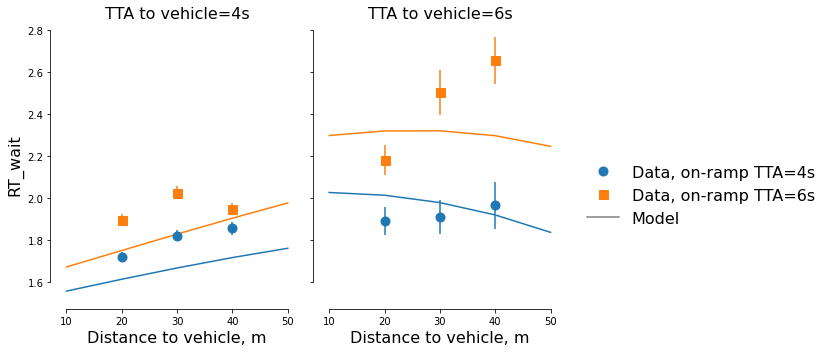

In [71]:
plot_var_by_condition(exp_measures, model_measures, var="RT_wait", model_label=model_label)

## Gaze-dependent drift & bound based on generalized gap

In [73]:
model_label="gaze_dependent_bound_generalized_gap_model"
model_measures = pd.read_csv("model_fit_results/%s/simulation_results/subj_all_measures.csv" % (model_label))

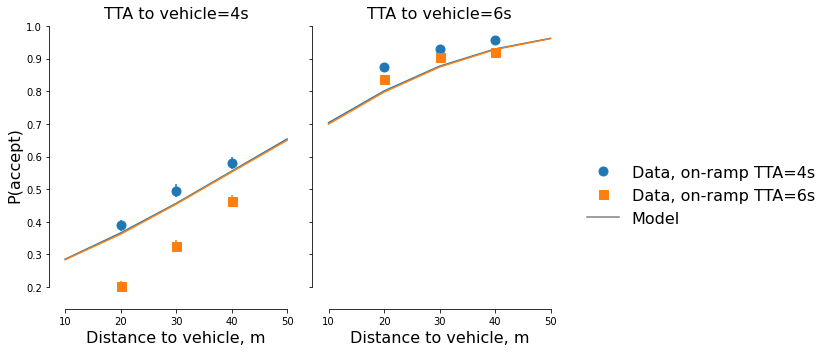

In [74]:
plot_var_by_condition(exp_measures, model_measures, var="is_gap_accepted", model_label=model_label)

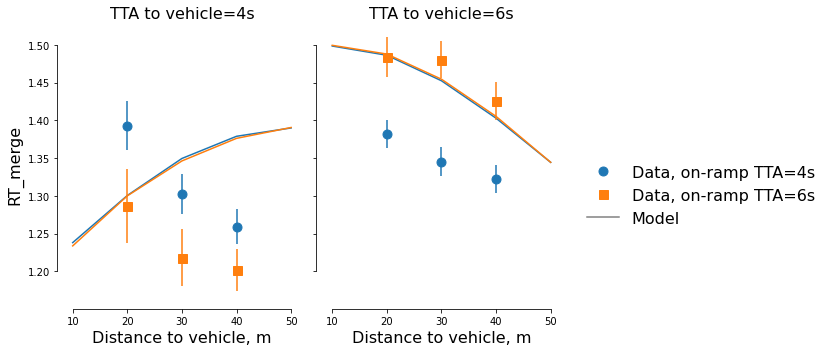

In [75]:
plot_var_by_condition(exp_measures, model_measures, var="RT_merge", model_label=model_label)

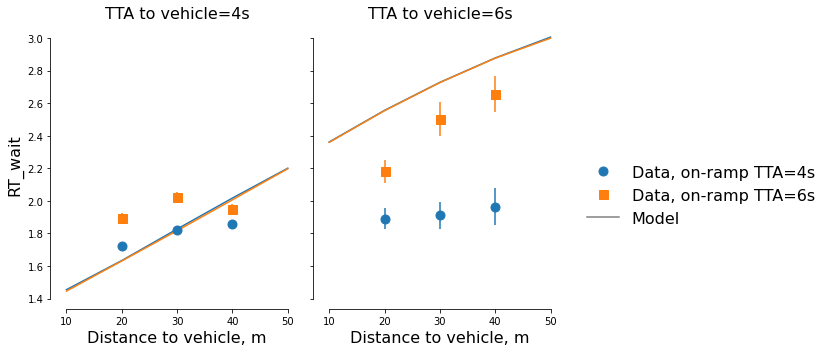

In [76]:
plot_var_by_condition(exp_measures, model_measures, var="RT_wait", model_label=model_label)

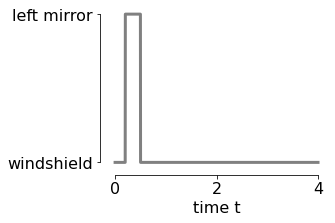

In [20]:
def get_gaze_sample(simulation_params):
    # In a typical trial, participants looked
    # 1) at the on-ramp for a short time - 300 ms
    # 2) at the mirror for 700 ms
    # 3) back at the on-ramp for the rest of the trial

    # return np.concatenate([np.zeros(int(0.2/simulation_params["dt"])), np.ones(int(1.0/simulation_params["dt"])),
    #                        np.zeros(int(0.1/simulation_params["dt"])), np.ones(int(0.2/simulation_params["dt"])),
    #                        np.zeros(int((simulation_params["duration"]-1.5)/simulation_params["dt"])+1)])

    return np.concatenate([np.zeros(int(0.2/simulation_params["dt"])), np.ones(int(0.3/simulation_params["dt"])),
                           np.zeros(int((simulation_params["duration"]-0.5)/simulation_params["dt"])+1)])

simulation_params = {"dt": 0.001, "duration": 4.0}

gaze_sample = get_gaze_sample(simulation_params)

plt.figure(figsize=(4, 3))
fontsize=16
plt.plot(np.linspace(0, simulation_params["duration"], len(gaze_sample)), gaze_sample, lw=3, color="grey")
ax = plt.gca()
ax.set_xlabel("time t", fontsize=fontsize)
ax.set_yticks([0, 1])
ax.set_yticklabels(["windshield", "left mirror"])
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sns.despine(offset=5, trim=True)
plt.savefig("output/gaze_sample_1.png", bbox_inches="tight")

# Effect of kinematic variables on dwell time

In [48]:
participant_means = exp_measures.groupby(["subj_id", "decision"])[["RT", "dwell_time"]].mean().reset_index()

In [49]:
participant_means

,subj_id,decision,RT,dwell_time
0,3,Merge,1.187791,0.678435
1,3,Wait,1.769851,0.653776
2,4,Merge,1.110974,0.652851
3,4,Wait,1.823989,0.610637
4,5,Merge,1.308333,0.894342
5,5,Wait,1.648130,0.894997
6,6,Merge,1.183122,0.494912
7,6,Wait,1.486222,0.473017
8,7,Merge,2.234293,0.445240
9,7,Wait,2.570247,0.488170


<Axes: xlabel='RT', ylabel='dwell_time'>

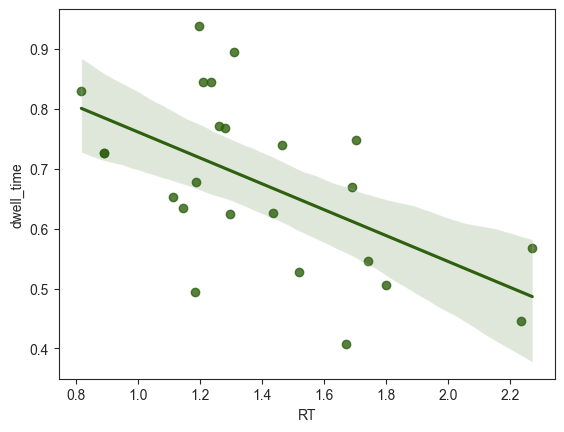

In [50]:
sns.regplot(participant_means[participant_means.decision=="Merge"], x="RT", y="dwell_time")

<Axes: xlabel='RT', ylabel='dwell_time'>

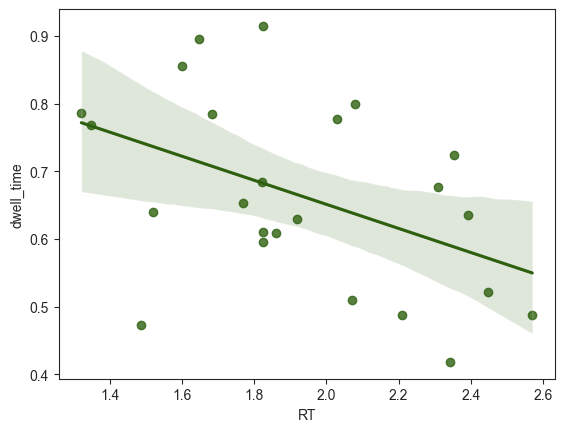

In [51]:
sns.regplot(participant_means[participant_means.decision=="Wait"], x="RT", y="dwell_time")

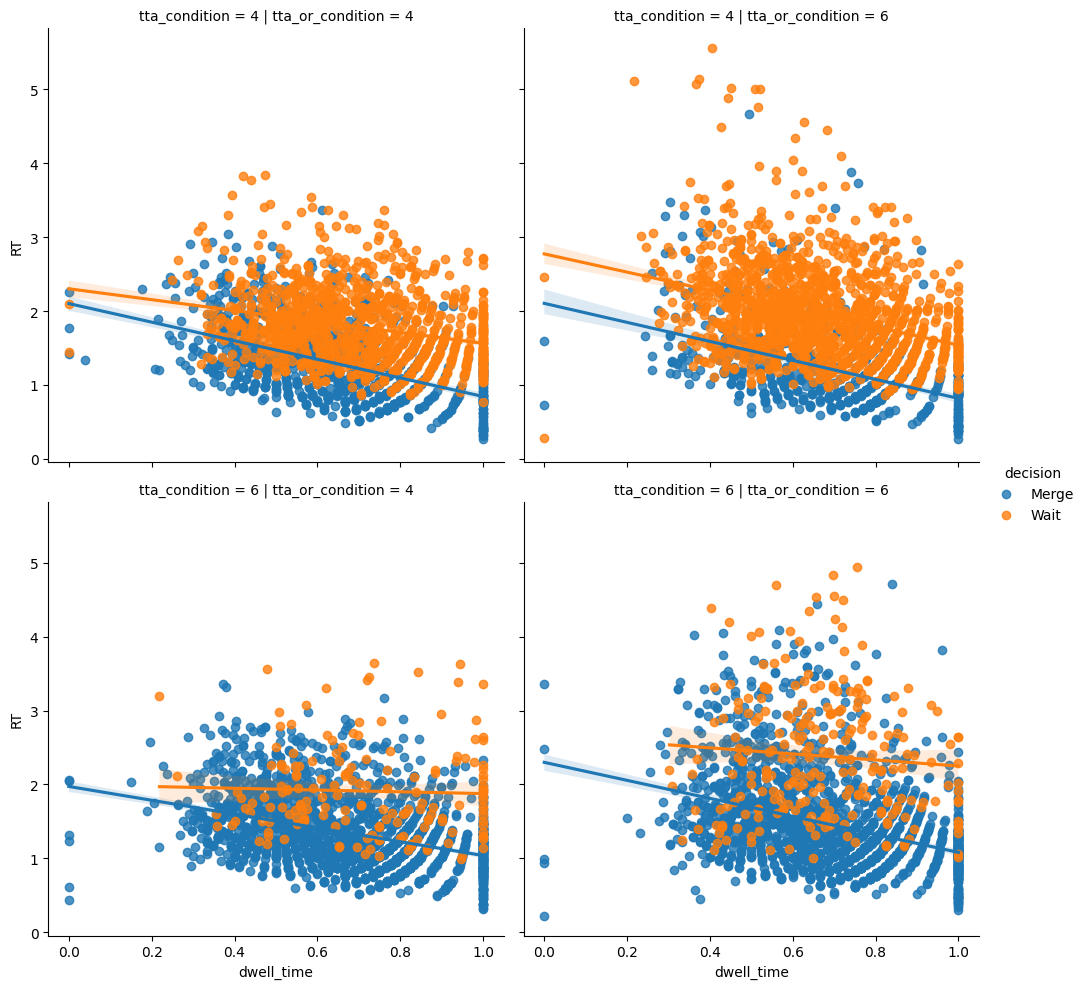

In [6]:
sns.lmplot(data=exp_measures, x="dwell_time", y="RT", hue="decision", col="tta_or_condition", row="tta_condition")

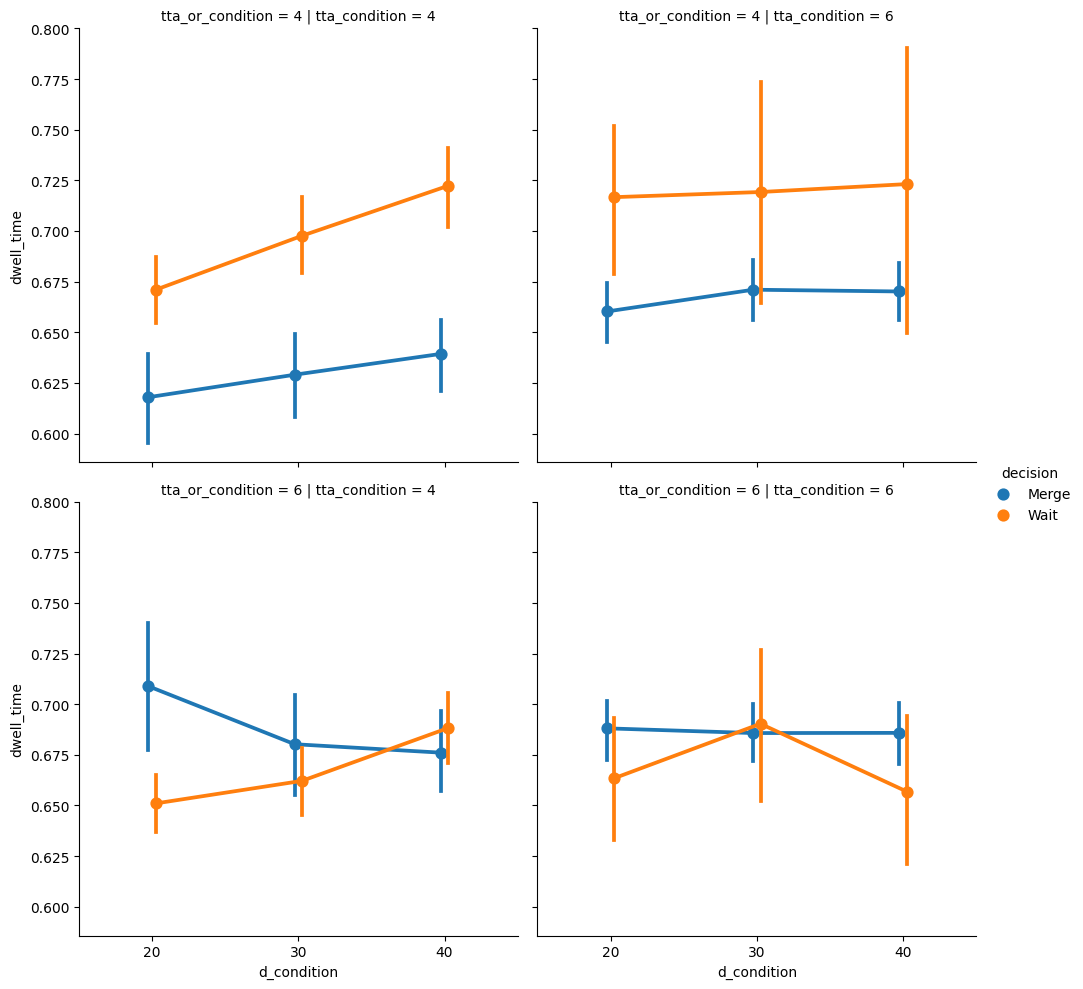

In [9]:
sns.catplot(data=exp_measures, x="d_condition", y="dwell_time", col="tta_condition", row="tta_or_condition" ,hue="decision", kind="point", dodge=True)

# Exploratory plots

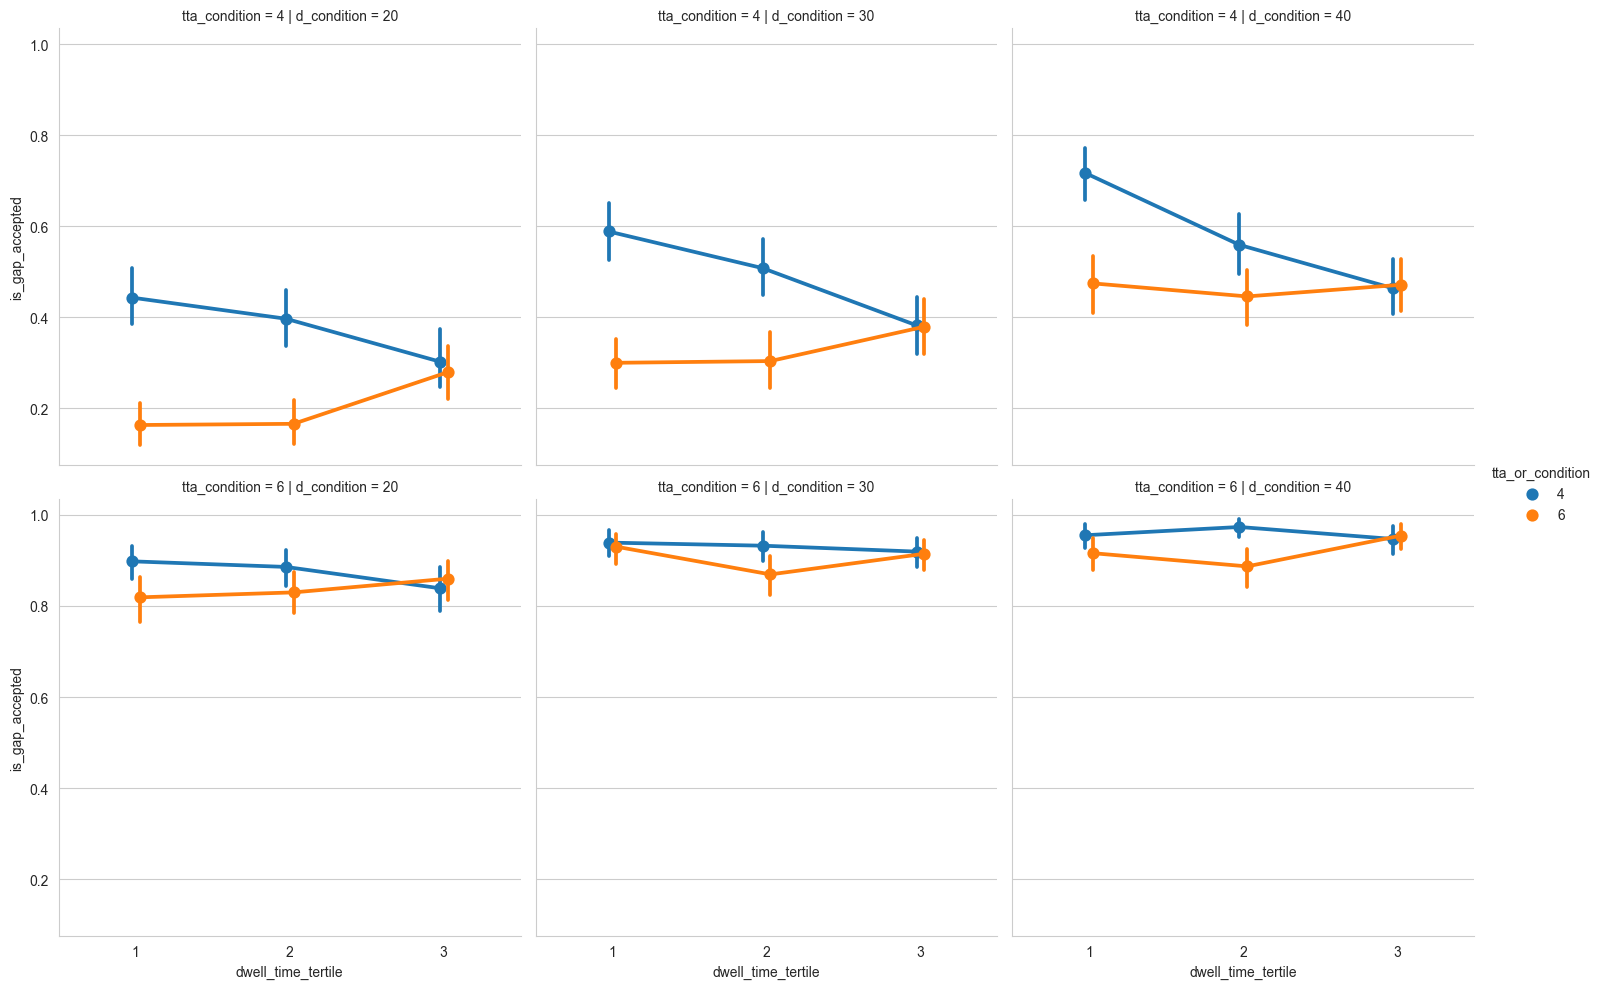

In [18]:
sns.catplot(data=exp_measures, x="dwell_time_tertile", y="is_gap_accepted", col="d_condition", row="tta_condition", hue="tta_or_condition", kind="point", dodge=True)

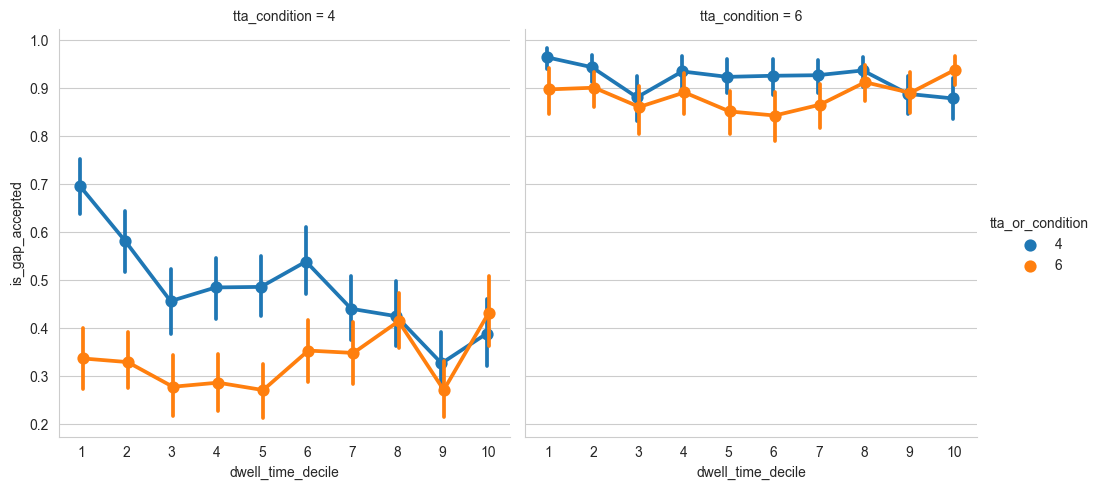

In [19]:
sns.catplot(data=exp_measures, x="dwell_time_decile", y="is_gap_accepted", col="tta_condition", hue="tta_or_condition", kind="point", dodge=True)

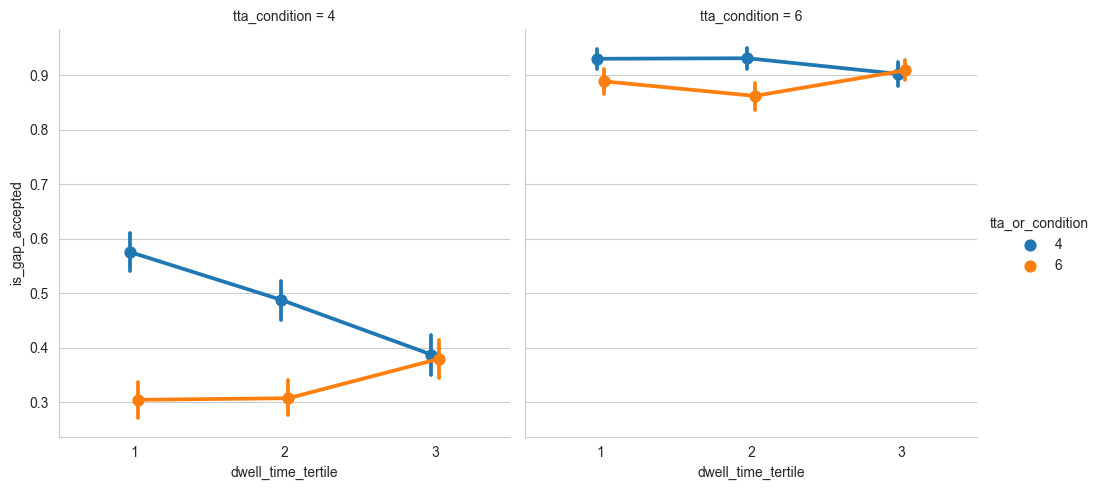

In [20]:
sns.catplot(data=exp_measures, x="dwell_time_tertile", y="is_gap_accepted", col="tta_condition", hue="tta_or_condition", kind="point", dodge=True)

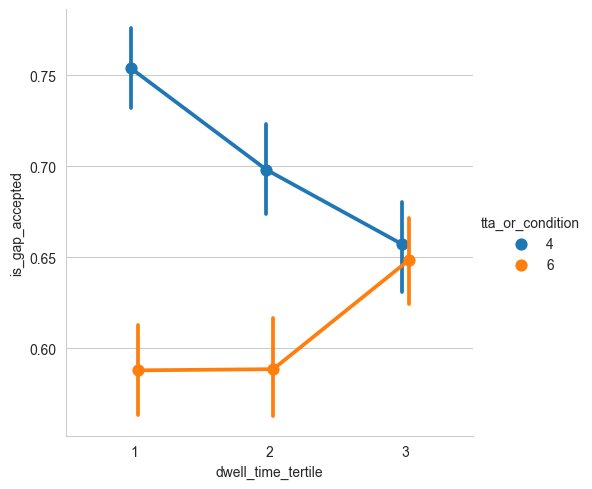

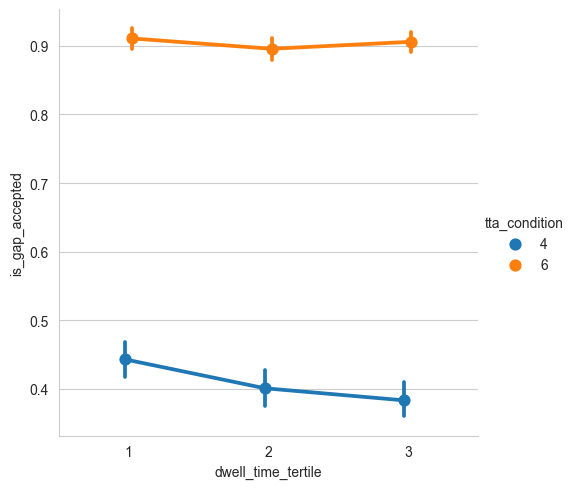

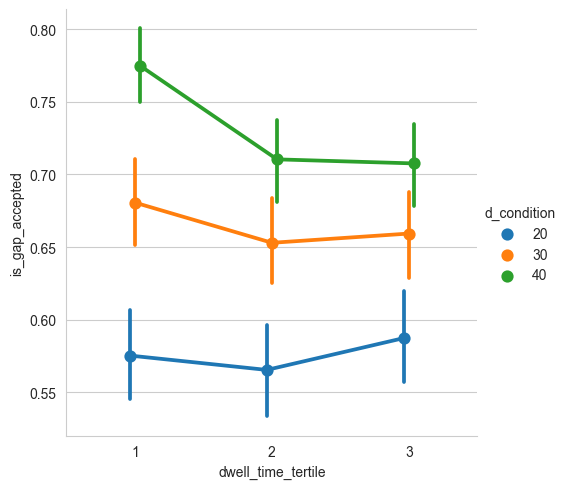

In [21]:
sns.catplot(data=exp_measures, x="dwell_time_tertile", y="is_gap_accepted", hue="tta_or_condition", kind="point", dodge=True)
sns.catplot(data=exp_measures, x="dwell_time_tertile", y="is_gap_accepted", hue="tta_condition", kind="point", dodge=True)
sns.catplot(data=exp_measures, x="dwell_time_tertile", y="is_gap_accepted", hue="d_condition", kind="point", dodge=True)

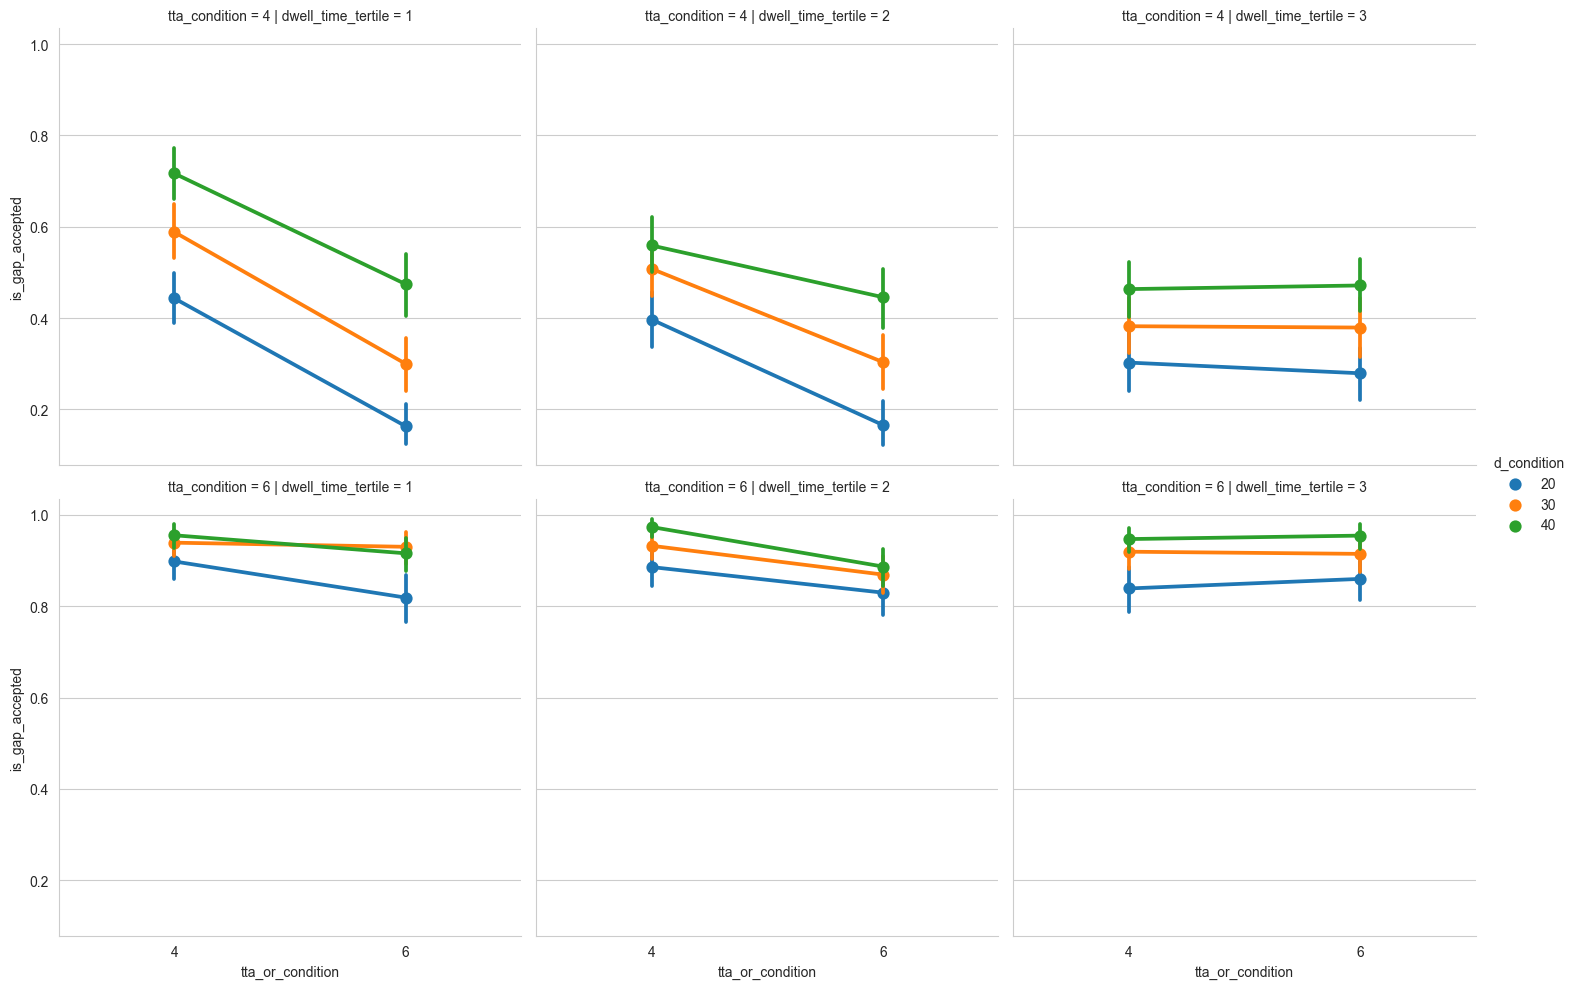

In [22]:
sns.catplot(data=exp_measures, x="tta_or_condition", y="is_gap_accepted", col="dwell_time_tertile", row="tta_condition", hue="d_condition", kind="point")

The effect of the information in the front view is modulated by dwell time

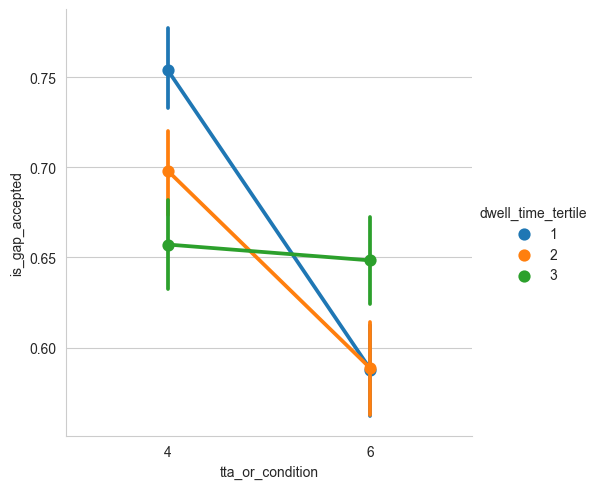

In [23]:
sns.catplot(data=exp_measures, x="tta_or_condition", y="is_gap_accepted", hue="dwell_time_tertile", kind="point")

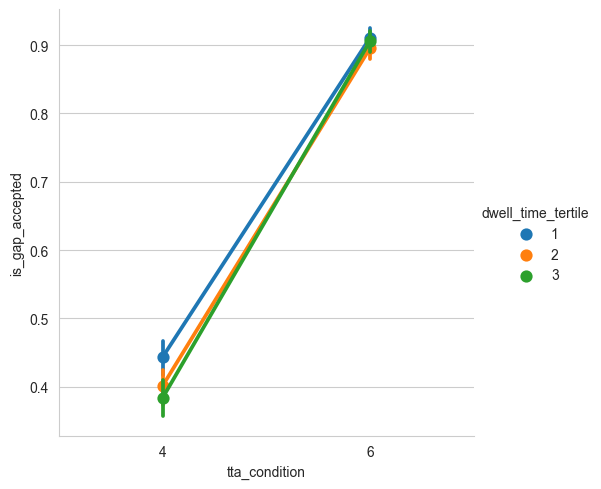

In [24]:
sns.catplot(data=exp_measures, x="tta_condition", y="is_gap_accepted", hue="dwell_time_tertile", kind="point")

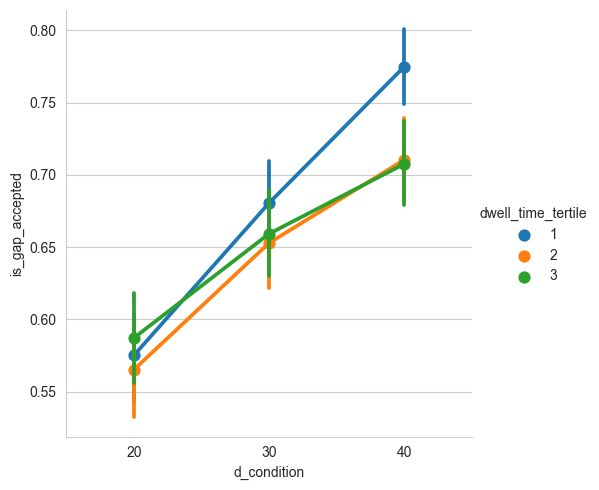

In [25]:
sns.catplot(data=exp_measures, x="d_condition", y="is_gap_accepted", hue="dwell_time_tertile", kind="point")

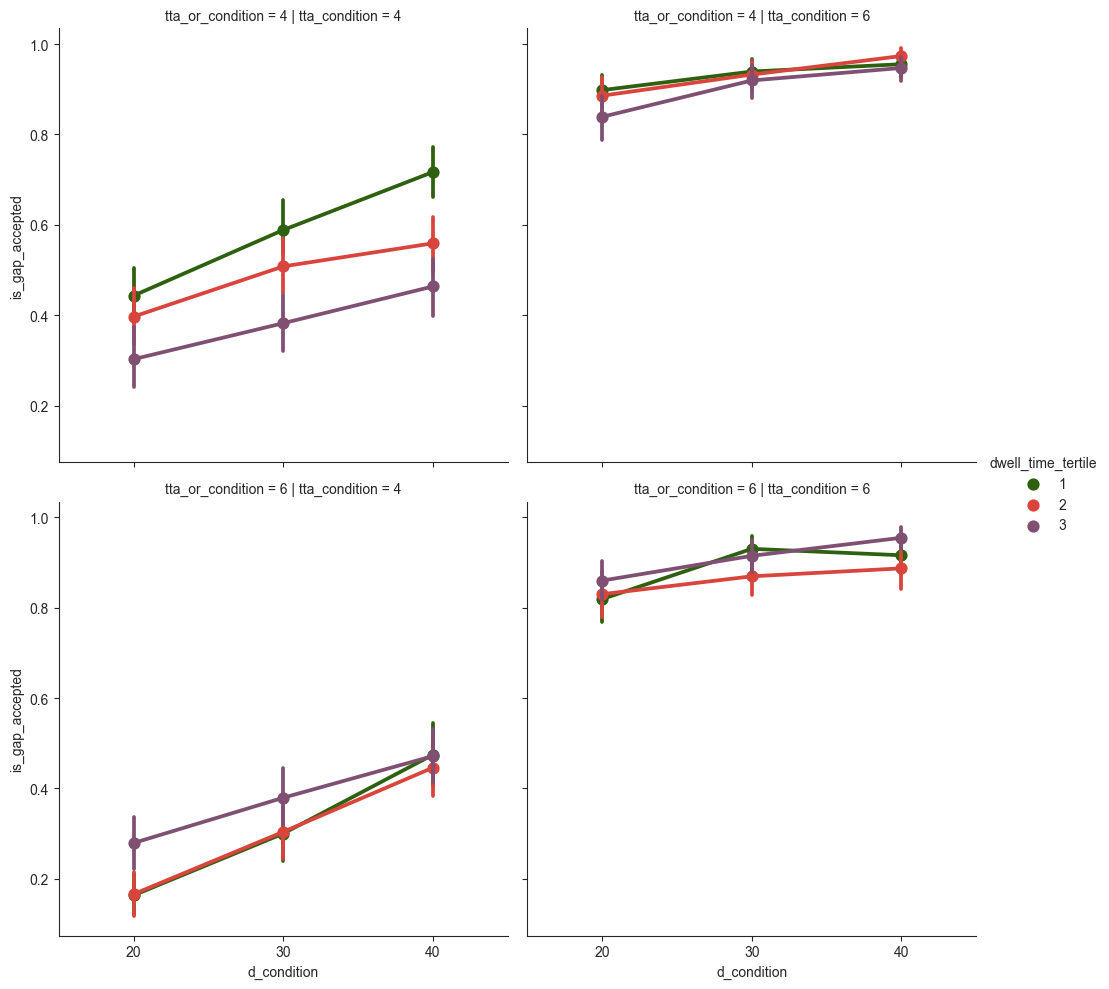

In [77]:
sns.catplot(data=exp_measures, x="d_condition", y="is_gap_accepted", col="tta_condition", row="tta_or_condition", hue="dwell_time_tertile", kind="point")   

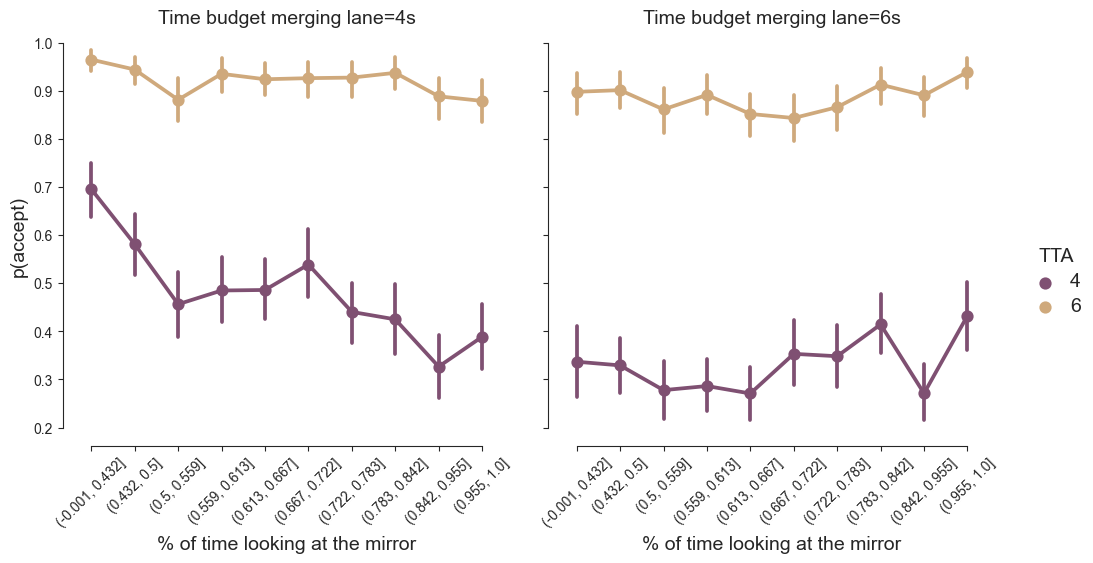

In [64]:
fontsize = 14
g = sns.catplot(data=exp_measures, x="dwell_time_decile", y="is_gap_accepted", col="tta_or_condition", hue="tta_condition", kind="point", palette=["C2", "C4"])
for ax, tta_condition in zip(g.axes[0], (4, 6)):
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("% of time looking at the mirror", fontsize=fontsize)
    ax.set_ylabel("p(accept)", fontsize=fontsize)
    ax.set_title("Time budget merging lane=%is" % tta_condition, fontsize=fontsize)
g.legend.set_title("TTA")
g.legend.get_title().set_fontsize(fontsize)
for text in g.legend.get_texts():
    text.set_fontsize(fontsize)
sns.despine(offset=5, trim=True)

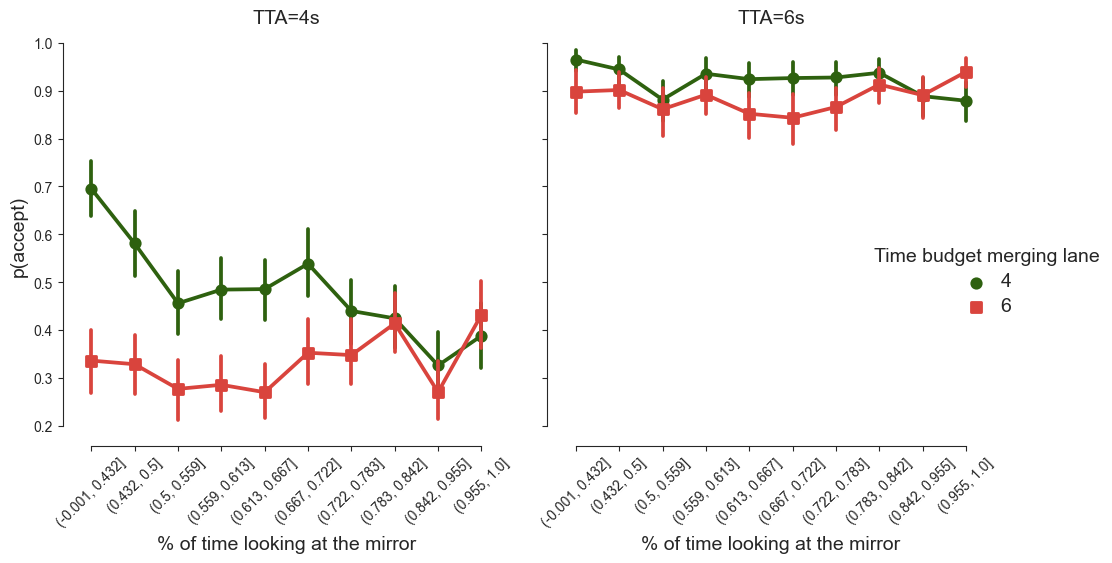

In [23]:
fontsize = 14
g = sns.catplot(data=exp_measures, x="dwell_time_decile", y="is_gap_accepted", col="tta_condition", hue="tta_or_condition", kind="point", markers=["o", "s"])
for ax, tta_condition in zip(g.axes[0], (4, 6)):
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("% of time looking at the mirror", fontsize=fontsize)
    ax.set_ylabel("p(accept)", fontsize=fontsize)
    ax.set_title("TTA=%is" % tta_condition, fontsize=fontsize)
g.legend.set_title("Time budget merging lane")
g.legend.get_title().set_fontsize(fontsize)
for text in g.legend.get_texts():
    text.set_fontsize(fontsize)
sns.despine(offset=5, trim=True)

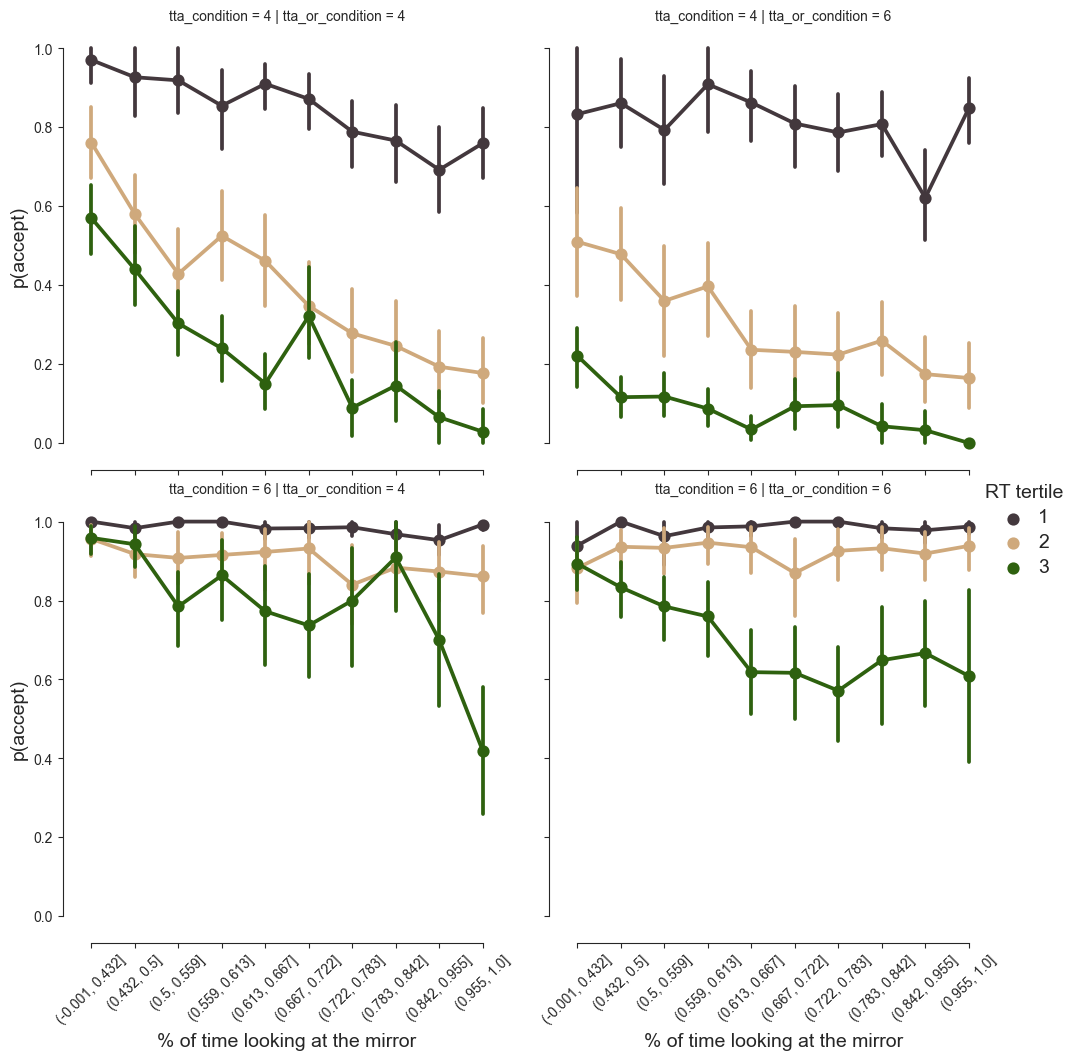

In [68]:
fontsize = 14
g = sns.catplot(data=exp_measures, x="dwell_time_decile", y="is_gap_accepted", col="tta_or_condition", row="tta_condition", hue="RT_tertile", kind="point", palette=["C3", "C4", "C5"])
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("% of time looking at the mirror", fontsize=fontsize)
    ax.set_ylabel("p(accept)", fontsize=fontsize)
    # ax.set_title("Time budget merging lane=%is" % tta_condition, fontsize=fontsize)
g.legend.set_title("RT tertile")
g.legend.get_title().set_fontsize(fontsize)
for text in g.legend.get_texts():
    text.set_fontsize(fontsize)
sns.despine(offset=5, trim=True)